<a href="https://colab.research.google.com/github/fshnkarimi/Labeling/blob/Ali/Time_Series_Labelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Reading Data

In [25]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
dfs = pd.read_excel("000001data.xlsx")

Implementing Labelling algorithm 

In [26]:
#labelling algorithm X is price and w is our threshould
def labeling(X,w):
    n = len(X)
    y = np.array([0 for i in range(n)])
    FP=X[0]
    xh = X[0]
    xl = X[0]
    HT = 0
    LT = 0
    cid = 0
    FP_N = 0
    for i in range(n):
        if(X[i] > FP + X[0]*w):
            xh,HT,FP_N,cid  = X[i],i,i,1
            break
        if(X[i] < FP - X[0]*w):
            xh,HT,FP_N,cid  = X[i],i,i,-1
            break
    for i in range(FP_N+1,n):
        if(cid > 0):
            if(X[i]>xh):
                xh,HT = X[i],i
            if(X[i] < xh - xh*w and LT<= HT ):
                for j in range(n):
                    if(j>LT and j<=HT):
                        y[j] = 1
                xl,LT,cid = X[i],i,-1
        if(cid < 0):
            if(X[i]<xl):
                xl,LT = X[i],i
            if(X[i] > xl + xl*w and HT<= LT ):
                for j in range(n):
                    if(j>HT and j<=LT):
                        y[j] = -1
                xh,HT,cid = X[i],i,1
    return y

labelling data

In [4]:
label=labeling(dfs["closingprice"],0.15)    

Creat windows with size 11 

In [28]:
closing_price= dfs['closingprice']

#windows size is 11
expand_data = np.array([closing_price[i:i+11] for i in range(len(closing_price) - 10) ])

normalize Data 
\begin{align*}
        f_{ij} & = \frac{x_{ij} - M^{\lambda}_{i}}{M^{\lambda}_{i}} ,x_{ij} \in X\\
        M^{\lambda}_{s}& = \frac{\sum_{i=s}^{s+ \lambda -1} x_i}{\lambda} , x_i \in x
    \end{align*}

In [29]:
#normalizatin
final_data_x = expand_data / np.mean(expand_data,axis = 1).reshape((len(expand_data) , 1))
final_data_x = final_data_x - np.ones((len(final_data_x) ,1))

In [30]:
#finalizing data
final_data_y = label[10:]
#split data to test and train
x_train = final_data_x[0:3011]
y_train = final_data_y[0:3011]
x_test= final_data_x[3011:]
y_test = final_data_y[3011:]

#(-1,1) --> (0,1)
y_train = (y_train + 1)//2
y_test = (y_test + 1)//2

x_train =x_train.reshape(x_train.shape[0],x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1], 1)



In [31]:
# Define a def for scores

from sklearn import metrics
import seaborn as sns

def scores(y_pred, label):
    print("Accuracy:{:.6f}".format(metrics.accuracy_score(label, y_pred)))
    print("Precision:{:.6f}".format(metrics.precision_score(label, y_pred)))
    print("Recall:{:.6f}".format(metrics.recall_score(label, y_pred)))
    print("F1 score:{:.6f}".format(metrics.f1_score(label, y_pred)))
    # Print Confusion Matrix
    confusion_matrix = pd.DataFrame(metrics.confusion_matrix(label, y_pred)) 
    sns.heatmap(confusion_matrix, annot=True, cmap="Blues");

Training data with 2 layer LSTM with hidden size 50 

Epoch 1/20
48/48 - 2s - loss: 0.6839 - accuracy: 0.5526 - val_loss: 0.7120 - val_accuracy: 0.5502
Epoch 2/20
48/48 - 0s - loss: 0.6314 - accuracy: 0.6712 - val_loss: 0.6684 - val_accuracy: 0.6193
Epoch 3/20
48/48 - 0s - loss: 0.5998 - accuracy: 0.6865 - val_loss: 0.6069 - val_accuracy: 0.6641
Epoch 4/20
48/48 - 0s - loss: 0.5584 - accuracy: 0.7174 - val_loss: 0.5998 - val_accuracy: 0.6855
Epoch 5/20
48/48 - 0s - loss: 0.5446 - accuracy: 0.7330 - val_loss: 0.6554 - val_accuracy: 0.6608
Epoch 6/20
48/48 - 0s - loss: 0.5435 - accuracy: 0.7283 - val_loss: 0.6093 - val_accuracy: 0.6892
Epoch 7/20
48/48 - 0s - loss: 0.5508 - accuracy: 0.7204 - val_loss: 0.5910 - val_accuracy: 0.6795
Epoch 8/20
48/48 - 0s - loss: 0.5394 - accuracy: 0.7283 - val_loss: 0.6092 - val_accuracy: 0.6657
Epoch 9/20
48/48 - 0s - loss: 0.5274 - accuracy: 0.7343 - val_loss: 0.6004 - val_accuracy: 0.6670
Epoch 10/20
48/48 - 0s - loss: 0.5326 - accuracy: 0.7280 - val_loss: 0.6036 - val_accuracy: 0.6855
Epoch 11/20
48/48 -

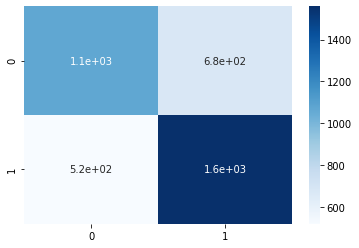

In [33]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
with tf.device('/device:GPU:0'):
  model=Sequential()
  model.add(tf.compat.v1.keras.layers.CuDNNLSTM(50,return_sequences=True,input_shape=(11,1)))
  model.add(Dropout(0.1))
  model.add(tf.compat.v1.keras.layers.CuDNNLSTM(50))
  model.add(Dropout(0.1))
  model.add(Dense(1, activation='sigmoid'))
  opt = tf.keras.optimizers.Adam(beta_1=0.9,beta_2=0.999,learning_rate=0.02)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=20,batch_size=64,verbose=2)
  
  # Predictions on test data
  preds = model.predict(x_test)
  preds = np.array([1 if y >= 0.5 else 0 for y in preds])
  scores(preds, y_test)

Training data with 2 layer GRU with hidden size 50 

Epoch 1/20
48/48 - 2s - loss: 0.6324 - accuracy: 0.6363 - val_loss: 0.7247 - val_accuracy: 0.5742
Epoch 2/20
48/48 - 0s - loss: 0.5690 - accuracy: 0.7081 - val_loss: 0.5995 - val_accuracy: 0.6793
Epoch 3/20
48/48 - 0s - loss: 0.5295 - accuracy: 0.7346 - val_loss: 0.6176 - val_accuracy: 0.6652
Epoch 4/20
48/48 - 0s - loss: 0.5514 - accuracy: 0.7224 - val_loss: 0.6070 - val_accuracy: 0.6793
Epoch 5/20
48/48 - 0s - loss: 0.5251 - accuracy: 0.7373 - val_loss: 0.6559 - val_accuracy: 0.6808
Epoch 6/20
48/48 - 0s - loss: 0.5206 - accuracy: 0.7429 - val_loss: 0.5959 - val_accuracy: 0.6780
Epoch 7/20
48/48 - 0s - loss: 0.5171 - accuracy: 0.7469 - val_loss: 0.5952 - val_accuracy: 0.6829
Epoch 8/20
48/48 - 0s - loss: 0.5067 - accuracy: 0.7502 - val_loss: 0.5911 - val_accuracy: 0.6858
Epoch 9/20
48/48 - 0s - loss: 0.5210 - accuracy: 0.7436 - val_loss: 0.5866 - val_accuracy: 0.6874
Epoch 10/20
48/48 - 0s - loss: 0.5084 - accuracy: 0.7519 - val_loss: 0.5965 - val_accuracy: 0.6936
Epoch 11/20
48/48 -

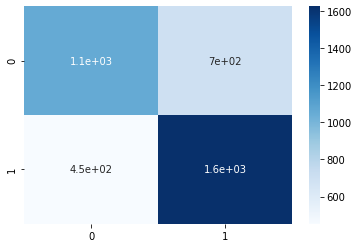

In [34]:
with tf.device('/device:GPU:0'):
  model=Sequential()
  model.add(tf.compat.v1.keras.layers.CuDNNGRU(50,return_sequences=True,input_shape=(11,1)))
  model.add(Dropout(0.1))
  model.add(tf.compat.v1.keras.layers.CuDNNGRU(50))
  model.add(Dropout(0.1))
  model.add(Dense(1, activation='sigmoid'))
  opt = tf.keras.optimizers.Adam(beta_1=0.9,beta_2=0.999,learning_rate=0.02)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=20,batch_size=64,verbose=2)

  # Predictions on test data
  preds = model.predict(x_test)
  preds = np.array([1 if y >= 0.5 else 0 for y in preds])
  scores(preds, y_test)

Training data with XGBoost

[0]	validation_0-auc:0.731009
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.731291
[2]	validation_0-auc:0.731218
[3]	validation_0-auc:0.731854
[4]	validation_0-auc:0.732589
[5]	validation_0-auc:0.732487
[6]	validation_0-auc:0.740994
[7]	validation_0-auc:0.743101
[8]	validation_0-auc:0.743565
[9]	validation_0-auc:0.742532
[10]	validation_0-auc:0.742988
[11]	validation_0-auc:0.742518
[12]	validation_0-auc:0.743228
[13]	validation_0-auc:0.74337
[14]	validation_0-auc:0.743477
[15]	validation_0-auc:0.743484
[16]	validation_0-auc:0.743919
[17]	validation_0-auc:0.74442
[18]	validation_0-auc:0.744942
[19]	validation_0-auc:0.74594
[20]	validation_0-auc:0.745706
[21]	validation_0-auc:0.746255
[22]	validation_0-auc:0.746086
[23]	validation_0-auc:0.746581
[24]	validation_0-auc:0.746946
[25]	validation_0-auc:0.746795
[26]	validation_0-auc:0.747
[27]	validation_0-auc:0.747143
[28]	validation_0-auc:0.74756
[29]	validation_0-auc:0.747364
[30]	validation_0-auc:0

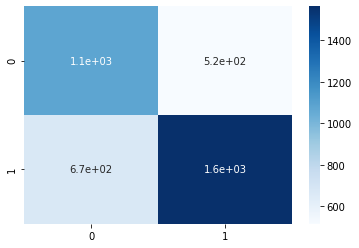

In [35]:
import xgboost as xgb
import numpy as np

X_train = x_train.reshape(x_train.shape[0],x_train.shape[1])
X_test = x_test.reshape(x_test.shape[0],x_test.shape[1])

# XGBoost classifier with Early-stopping
clf = xgb.XGBClassifier(n_jobs=1)
clf.fit(X_train, y_train, early_stopping_rounds=50, eval_metric="auc",
        eval_set=[(X_test, y_test)])

preds = clf.predict(X_test)
scores(y_test, preds)


#My approach

sampling form 44 previous data with sample size 11 and equal distance between samples

In [36]:
expand_data = np.array([closing_price[i:i+44] for i in range(len(closing_price) - 43) ])


#x_df = np.array([np.convolve(x,np.ones(4)/4,mode='valid') for x in x_df])
final_data_x = np.array([np.array([x[i] for i in range(3,44,4)]) for x in expand_data])
final_data_x = final_data_x / np.mean(final_data_x,axis = 1).reshape((len(final_data_x) , 1))
final_data_x = final_data_x - np.ones((len(final_data_x) ,1))

final_data_y = label[43:]


x_train = final_data_x[0:3011]
y_train = final_data_y[0:3011]
x_test= final_data_x[3011:]
y_test = final_data_y[3011:]


y_train = (y_train + 1)//2
y_test = (y_test + 1)//2


x_train =x_train.reshape(x_train.shape[0],x_train.shape[1] , 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1] , 1)


Epoch 1/20
48/48 - 2s - loss: 0.6192 - accuracy: 0.6503 - val_loss: 0.6105 - val_accuracy: 0.6833
Epoch 2/20
48/48 - 0s - loss: 0.5252 - accuracy: 0.7416 - val_loss: 0.5356 - val_accuracy: 0.7154
Epoch 3/20
48/48 - 0s - loss: 0.4915 - accuracy: 0.7639 - val_loss: 0.5365 - val_accuracy: 0.7207
Epoch 4/20
48/48 - 0s - loss: 0.4699 - accuracy: 0.7755 - val_loss: 0.5374 - val_accuracy: 0.7228
Epoch 5/20
48/48 - 0s - loss: 0.4620 - accuracy: 0.7825 - val_loss: 0.6452 - val_accuracy: 0.6418
Epoch 6/20
48/48 - 0s - loss: 0.4622 - accuracy: 0.7838 - val_loss: 0.5683 - val_accuracy: 0.6710
Epoch 7/20
48/48 - 0s - loss: 0.4539 - accuracy: 0.7888 - val_loss: 0.5458 - val_accuracy: 0.7186
Epoch 8/20
48/48 - 0s - loss: 0.4154 - accuracy: 0.8080 - val_loss: 0.5499 - val_accuracy: 0.7199
Epoch 9/20
48/48 - 0s - loss: 0.4215 - accuracy: 0.8080 - val_loss: 0.6282 - val_accuracy: 0.6702
Epoch 10/20
48/48 - 0s - loss: 0.4020 - accuracy: 0.8117 - val_loss: 0.5677 - val_accuracy: 0.7070
Epoch 11/20
48/48 -

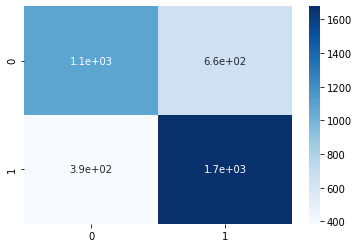

In [37]:
with tf.device('/device:GPU:0'):
  model=Sequential()
  model.add(tf.compat.v1.keras.layers.CuDNNGRU(50,return_sequences=True,input_shape=(11,1)))
  model.add(Dropout(0.1))
  model.add(tf.compat.v1.keras.layers.CuDNNGRU(50))
  model.add(Dropout(0.1))
  model.add(Dense(1, activation='sigmoid'))
  opt = tf.keras.optimizers.Adam(beta_1=0.9,beta_2=0.999,learning_rate=0.02)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=20,batch_size=64,verbose=2)

  # Predictions on test data
  preds = model.predict(x_test)
  preds = np.array([1 if y >= 0.5 else 0 for y in preds])
  scores(preds, y_test)

Epoch 1/20
48/48 - 2s - loss: 0.6088 - accuracy: 0.6745 - val_loss: 0.5834 - val_accuracy: 0.6502
Epoch 2/20
48/48 - 0s - loss: 0.5226 - accuracy: 0.7469 - val_loss: 0.5335 - val_accuracy: 0.7291
Epoch 3/20
48/48 - 0s - loss: 0.4920 - accuracy: 0.7629 - val_loss: 0.5357 - val_accuracy: 0.7133
Epoch 4/20
48/48 - 0s - loss: 0.5271 - accuracy: 0.7479 - val_loss: 0.5398 - val_accuracy: 0.7320
Epoch 5/20
48/48 - 0s - loss: 0.4923 - accuracy: 0.7679 - val_loss: 0.5166 - val_accuracy: 0.7454
Epoch 6/20
48/48 - 0s - loss: 0.4777 - accuracy: 0.7728 - val_loss: 0.5288 - val_accuracy: 0.7265
Epoch 7/20
48/48 - 0s - loss: 0.4723 - accuracy: 0.7808 - val_loss: 0.5418 - val_accuracy: 0.7128
Epoch 8/20
48/48 - 0s - loss: 0.4644 - accuracy: 0.7825 - val_loss: 0.5271 - val_accuracy: 0.7317
Epoch 9/20
48/48 - 0s - loss: 0.4471 - accuracy: 0.7944 - val_loss: 0.5609 - val_accuracy: 0.7057
Epoch 10/20
48/48 - 0s - loss: 0.4946 - accuracy: 0.7639 - val_loss: 0.5302 - val_accuracy: 0.7341
Epoch 11/20
48/48 -

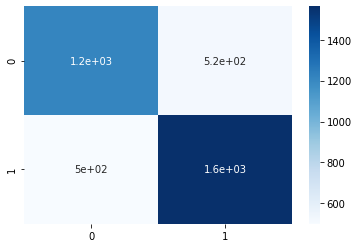

In [39]:
with tf.device('/device:GPU:0'):
  model=Sequential()
  model.add(tf.compat.v1.keras.layers.CuDNNGRU(50,return_sequences=True,input_shape=(11,1)))
  model.add(Dropout(0.1))
  model.add(tf.compat.v1.keras.layers.CuDNNGRU(50))
  model.add(Dropout(0.1))
  model.add(Dense(1, activation='sigmoid'))
  opt = tf.keras.optimizers.Adam(beta_1=0.9,beta_2=0.999,learning_rate=0.02)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=20,batch_size=64,verbose=2)

  # Predictions on test data
  preds = model.predict(x_test)
  preds = np.array([1 if y >= 0.5 else 0 for y in preds])
  scores(preds, y_test)

XGBoost on new approach

[0]	validation_0-auc:0.784383
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.78591
[2]	validation_0-auc:0.794936
[3]	validation_0-auc:0.798763
[4]	validation_0-auc:0.800806
[5]	validation_0-auc:0.801058
[6]	validation_0-auc:0.801886
[7]	validation_0-auc:0.801478
[8]	validation_0-auc:0.80242
[9]	validation_0-auc:0.804822
[10]	validation_0-auc:0.804515
[11]	validation_0-auc:0.803101
[12]	validation_0-auc:0.803229
[13]	validation_0-auc:0.801766
[14]	validation_0-auc:0.802255
[15]	validation_0-auc:0.802485
[16]	validation_0-auc:0.803993
[17]	validation_0-auc:0.804558
[18]	validation_0-auc:0.804713
[19]	validation_0-auc:0.804486
[20]	validation_0-auc:0.805602
[21]	validation_0-auc:0.804159
[22]	validation_0-auc:0.804091
[23]	validation_0-auc:0.806169
[24]	validation_0-auc:0.806494
[25]	validation_0-auc:0.80419
[26]	validation_0-auc:0.804639
[27]	validation_0-auc:0.805265
[28]	validation_0-auc:0.804684
[29]	validation_0-auc:0.804643
[30]	validation_0-a

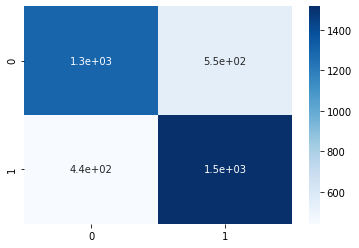

In [40]:
import xgboost as xgb
import numpy as np

X_train = x_train.reshape(x_train.shape[0],x_train.shape[1])
X_test = x_test.reshape(x_test.shape[0],x_test.shape[1])

# XGBoost classifier with Early-stopping
clf = xgb.XGBClassifier(n_jobs=1)
clf.fit(X_train, y_train, early_stopping_rounds=50, eval_metric="auc",
        eval_set=[(X_test, y_test)])

preds = clf.predict(X_test)
scores(y_test, preds)